In [18]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from scipy.spatial.distance import pdist, squareform, cdist
import seaborn as sns

# 1. Dataset Preparation

## 1.1 Loading Dataset

In [19]:
dataset = pd.read_csv("data/final_dataset.csv")
print("Shape of dataset:", dataset.shape)
dataset.head()

Shape of dataset: (239381, 74)


,date,year,populous_city,latitude,longitude,min_age_participants,avg_age_participants,max_age_participants,teen_ratio,adults_ratio,...,state_Texas,state_Utah,state_Vermont,state_Virginia,state_Washington,state_West Virginia,state_Wisconsin,state_Wyoming,month_x,month_y
0,771.0,2015.0,1,39.8322,-86.2492,19.0,19.0,19.0,0.0,1.0,...,False,False,False,False,False,False,False,False,5.000000e-01,-0.866025
1,1491.0,2017.0,0,41.6645,-78.7856,62.0,62.0,62.0,0.0,1.0,...,False,False,False,False,False,False,False,False,8.660254e-01,-0.500000
2,1131.0,2016.0,1,42.4190,-83.0393,15.0,15.0,15.0,0.0,1.0,...,False,False,False,False,False,False,False,False,-5.000000e-01,0.866025
3,1132.0,2016.0,1,38.9030,-76.9820,19.0,22.0,24.0,0.0,1.0,...,False,False,False,False,False,False,False,False,-8.660254e-01,0.500000
4,770.0,2015.0,0,40.4621,-80.0308,37.0,37.0,37.0,0.0,1.0,...,False,False,False,False,False,False,False,False,1.224647e-16,-1.000000


In [20]:
print("There are NaN values:", dataset.isnull().values.any())

There are NaN values: False


In [21]:
print(dataset.columns)

Index(['date', 'year', 'populous_city', 'latitude', 'longitude',
       'min_age_participants', 'avg_age_participants', 'max_age_participants',
       'teen_ratio', 'adults_ratio', 'males_ratio', 'killed_ratio',
       'injured_ratio', 'arrested_ratio', 'n_participants',
       'povertyPercentage', 'party', 'totalvotes', 'republicans_ratio',
       'democrats_ratio', 'state_population', 'state_Alabama', 'state_Alaska',
       'state_Arizona', 'state_Arkansas', 'state_California', 'state_Colorado',
       'state_Connecticut', 'state_Delaware', 'state_District of Columbia',
       'state_Florida', 'state_Georgia', 'state_Hawaii', 'state_Idaho',
       'state_Illinois', 'state_Indiana', 'state_Iowa', 'state_Kansas',
       'state_Kentucky', 'state_Louisiana', 'state_Maine', 'state_Maryland',
       'state_Massachusetts', 'state_Michigan', 'state_Minnesota',
       'state_Mississippi', 'state_Missouri', 'state_Montana',
       'state_Nebraska', 'state_Nevada', 'state_New Hampshire',
      

In [22]:
dropped_columns = [c for c in dataset.columns if c.startswith('state_')]
dropped_columns += ['min_age_participants', 'max_age_participants', 'teen_ratio', 'totalvotes']
print("Attributes to drop:", dropped_columns)
dataset_reduced = dataset.drop(columns=dropped_columns, axis = 1)
print("Shape of dataset:", dataset_reduced.shape)

Attributes to drop: ['state_population', 'state_Alabama', 'state_Alaska', 'state_Arizona', 'state_Arkansas', 'state_California', 'state_Colorado', 'state_Connecticut', 'state_Delaware', 'state_District of Columbia', 'state_Florida', 'state_Georgia', 'state_Hawaii', 'state_Idaho', 'state_Illinois', 'state_Indiana', 'state_Iowa', 'state_Kansas', 'state_Kentucky', 'state_Louisiana', 'state_Maine', 'state_Maryland', 'state_Massachusetts', 'state_Michigan', 'state_Minnesota', 'state_Mississippi', 'state_Missouri', 'state_Montana', 'state_Nebraska', 'state_Nevada', 'state_New Hampshire', 'state_New Jersey', 'state_New Mexico', 'state_New York', 'state_North Carolina', 'state_North Dakota', 'state_Ohio', 'state_Oklahoma', 'state_Oregon', 'state_Pennsylvania', 'state_Rhode Island', 'state_South Carolina', 'state_South Dakota', 'state_Tennessee', 'state_Texas', 'state_Utah', 'state_Vermont', 'state_Virginia', 'state_Washington', 'state_West Virginia', 'state_Wisconsin', 'state_Wyoming', 'min_ag

In [23]:
numeric_dataset = dataset_reduced._get_numeric_data()
print("Shape of numeric_dataset:", numeric_dataset.shape)
numeric_dataset.head()

Shape of numeric_dataset: (239381, 18)


,date,year,populous_city,latitude,longitude,avg_age_participants,adults_ratio,males_ratio,killed_ratio,injured_ratio,arrested_ratio,n_participants,povertyPercentage,party,republicans_ratio,democrats_ratio,month_x,month_y
0,771.0,2015.0,1,39.8322,-86.2492,19.0,1.0,1.0,0.0,1.0,0.0,1.0,12.3,0,0.452677,0.547323,5.000000e-01,-0.866025
1,1491.0,2017.0,0,41.6645,-78.7856,62.0,1.0,1.0,1.0,0.0,0.0,1.0,10.5,1,0.671644,0.328356,8.660254e-01,-0.500000
2,1131.0,2016.0,1,42.4190,-83.0393,15.0,1.0,0.5,0.0,0.5,0.0,2.0,11.0,0,0.214934,0.785066,-5.000000e-01,0.866025
3,1132.0,2016.0,1,38.9030,-76.9820,22.0,1.0,1.0,0.0,1.0,0.0,2.0,14.9,1,0.609639,0.390361,-8.660254e-01,0.500000
4,770.0,2015.0,0,40.4621,-80.0308,37.0,1.0,1.0,0.0,0.5,0.0,2.0,11.5,0,0.000000,1.000000,1.224647e-16,-1.000000


## 1.2 Outlier detection

In [24]:
def return_whiskers(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_whisker = q1 - 1.5 * iqr
    upper_whisker = q3 + 1.5 * iqr
    return lower_whisker, upper_whisker

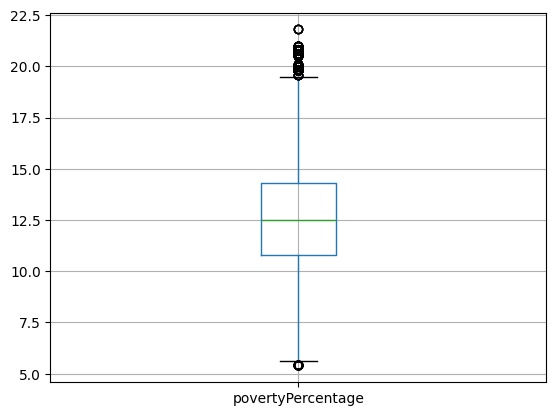

In [25]:
boxplot = dataset_reduced.boxplot(column=['povertyPercentage'])
plt.show()

In [26]:
lower_whisker_poverty, upper_whisker_poverty = return_whiskers(dataset_reduced, 'povertyPercentage')
print("Amount of outliers in povertyPercentage:", dataset_reduced[(dataset_reduced['povertyPercentage'] < lower_whisker_poverty) | (dataset_reduced['povertyPercentage'] > upper_whisker_poverty)].shape[0])

Amount of outliers in povertyPercentage: 7379


Values for poverty percentages that are outliers are still realistic and close to whiskers. Furthermore, poverty percentage is a key attribute of our analysis, so we decide to keep all the data points.

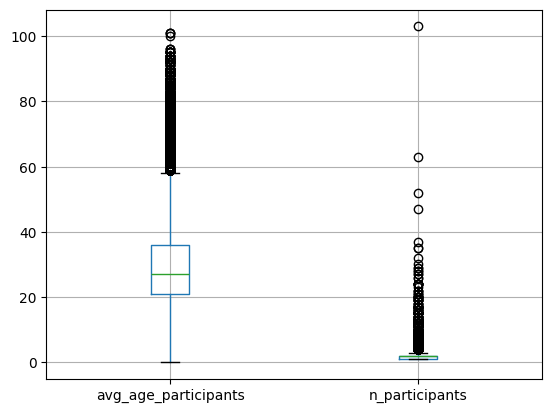

In [27]:
boxplot = dataset_reduced.boxplot(column = ['avg_age_participants', 'n_participants'])
plt.show()

Drop outliers for unrealistic values of avg age participants which may negatively influence clustering.

In [28]:
# Get whisker value of boxplot for avg_age_participants
lower_whisker_avg_age, upper_whisker_avg_age = return_whiskers(dataset_reduced, 'avg_age_participants')

# Drop rows with avg_age_participants > upper_whisker
dataset_reduced = dataset_reduced[dataset_reduced['avg_age_participants'] <= upper_whisker_avg_age]
print("Shape of dataset:", dataset_reduced.shape)

Shape of dataset: (230888, 18)


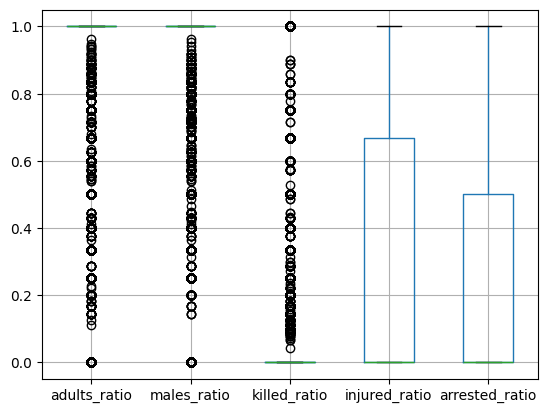

In [29]:
boxplot = dataset_reduced.boxplot(column = ['adults_ratio', 'males_ratio', 'killed_ratio', 'injured_ratio', 'arrested_ratio'])
plt.show()

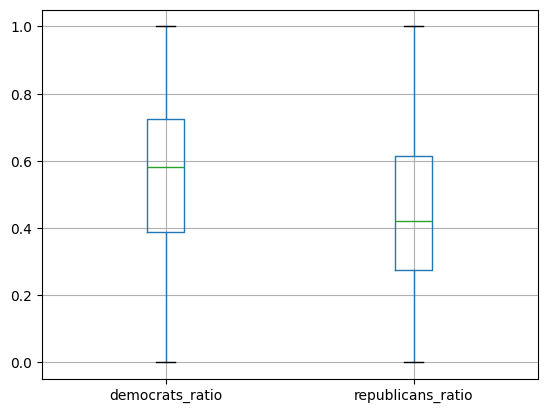

In [30]:
boxplot = dataset_reduced.boxplot(column = ['democrats_ratio', 'republicans_ratio'])
plt.show()

In [31]:
print('Check if sum of democrats_ratio and republicans_ratio is 1 in every row:', (dataset_reduced['democrats_ratio'] + dataset_reduced['republicans_ratio'] == 1).all())
print('Check how many rows have sum of democrats_ratio and republicans_ratio not equal to 1:', (dataset_reduced['democrats_ratio'] + dataset_reduced['republicans_ratio'] != 1).sum())
print("Amount of reublicans_ratio outliers:", dataset_reduced[dataset_reduced['republicans_ratio'] == 1].shape[0] + dataset_reduced[dataset_reduced['republicans_ratio'] == 0].shape[0])
print("Amount of democrats_ratio outliers:", dataset_reduced[dataset_reduced['democrats_ratio'] == 1].shape[0] + dataset_reduced[dataset_reduced['democrats_ratio'] == 0].shape[0])

Check if sum of democrats_ratio and republicans_ratio is 1 in every row: False
Check how many rows have sum of democrats_ratio and republicans_ratio not equal to 1: 9797
Amount of reublicans_ratio outliers: 7371
Amount of democrats_ratio outliers: 7371


In [32]:
# Check how many times a party won and the percentage of votes for that part was <0.5
democrats_strange = len(dataset_reduced[(dataset_reduced['republicans_ratio'] > 0.5 ) & (dataset_reduced['party'] == 0)])
republicans_strange = len(dataset_reduced[(dataset_reduced['republicans_ratio'] < 0.5 ) & (dataset_reduced['party'] == 1)])

print("Amount of times democrats won and the percentage of votes for that part was <0.5:", democrats_strange)
print("Amount of times republicans won and the percentage of votes for that part was <0.5:", republicans_strange)
print("Amount of strange wins:", democrats_strange + republicans_strange)

Amount of times democrats won and the percentage of votes for that part was <0.5: 2982
Amount of times republicans won and the percentage of votes for that part was <0.5: 5702
Amount of strange wins: 8684


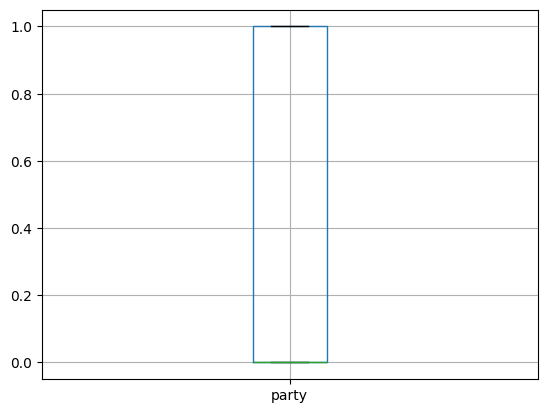

In [33]:
boxplot = dataset_reduced.boxplot(column = ['party'])
plt.show()

In [34]:
boxplot = dataset_reduced.boxplot(column = [ 'population'])

#### FUTURE : LOOK AT CITY DIMENSION HERE ####

plt.show()

KeyError: "None of [Index(['population'], dtype='object')] are in the [columns]"

In [ ]:
boxplot = dataset_reduced.boxplot(column = ['party'])
plt.show()

## 1.3 Scaling

In [ ]:
scaler = MinMaxScaler()
scaled_dataset = scaler.fit_transform(numeric_dataset.values)
scaled_dataset.shape

# 2. K Means

## 2.1 Identification of the best value of k

In [ ]:
sse_list = []
silhouette_list = []
davies_bouldin_list = []

max_k = 20
for k in tqdm(range(2, max_k + 1), ):
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(scaled_dataset)

    sse_list.append(kmeans.inertia_)
    silhouette_list.append(silhouette_score(scaled_dataset, kmeans.labels_, sample_size=10000))
    davies_bouldin_list.append(davies_bouldin_score(scaled_dataset, kmeans.labels_))

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(20, 15))
ax[0].plot(range(2, len(sse_list) + 2), sse_list)
ax[0].set_ylabel('SSE', fontsize=22)
ax[0].set_xticks(range(2, len(sse_list) + 2))

ax[1].plot(range(2, len(silhouette_list) + 2), silhouette_list)
ax[1].set_ylabel('Silhouette Score', fontsize=22)
ax[1].set_xticks(range(2, len(silhouette_list) + 2))

ax[2].plot(range(2, len(davies_bouldin_list) + 2), davies_bouldin_list)
ax[2].set_ylabel('Davies Bouldin Score', fontsize=22)
ax[2].set_xticks(range(2, len(davies_bouldin_list) + 2))


plt.xlabel('K', fontsize=22)
plt.show()

# NICER PLOTS

## 2.2 Analysis of the centroids and clusters

In [ ]:
n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters, n_init=10)
kmeans.fit(scaled_dataset)

In [ ]:
print("Shape of scaled_dataset: ", scaled_dataset.shape)
print("Shape of kmeans.labels_: ", kmeans.labels_.shape)
print("Shape of kmeans.cluster_centers_: ", kmeans.cluster_centers_.shape)

In [ ]:
centers = scaler.inverse_transform(kmeans.cluster_centers_)
centers_df = pd.DataFrame(centers, columns=numeric_dataset.columns)
centers_df.head(7)

In [ ]:
cluster_num_points = []
cluster_points = []
for i in range(n_clusters):
    cluster_points.append(scaled_dataset[kmeans.labels_ == i])
    cluster_num_points.append(len(cluster_points[-1]))
    
cluster_num_points, cluster_points[0].shape

In [ ]:
kmeans_tot = KMeans(n_clusters=1, n_init=10)
kmeans_tot.fit(scaled_dataset)
total_SSE = kmeans_tot.inertia_ / len(scaled_dataset)

cluster_SSE = []
for i in range(n_clusters):
    cluster_sse = 0
    for point in cluster_points[i]:
        cluster_sse += np.linalg.norm(point - kmeans.cluster_centers_[i])**2
    cluster_SSE.append(cluster_sse / cluster_num_points[i])

print("Cluster SSE: ", cluster_SSE)
print("Total SSE: ", total_SSE)
print("SSE of cluster with min SSE: ", min(cluster_SSE))
print("SSE of cluster with max SSE: ", max(cluster_SSE))
print("Mean of SSE: ", np.mean(cluster_SSE))

In [ ]:
cluster_distance_variance = []
total_distance_variance = 0
dataset_centroid = np.mean(scaled_dataset, axis=0)

###### CI RIPENSIAMO SU QUESTO ######
for point in scaled_dataset:
    total_distance_variance += (np.linalg.norm(point - dataset_centroid)**2 - total_SSE) ** 2
total_distance_variance /= len(scaled_dataset)
#####################################

for i in range(n_clusters):
    variance = 0
    for p in cluster_points[i]:
        variance += ((np.linalg.norm(p - kmeans.cluster_centers_[i]))**2 - cluster_SSE[i])**2
    cluster_distance_variance.append(variance/cluster_num_points[i])

print("Cluster distance variance: ", cluster_distance_variance)
print("Total distance variance: ", total_distance_variance)
print("Distance variance of cluster with min SSE: ", min(cluster_distance_variance))
print("Distance variance of cluster with max SSE: ", max(cluster_distance_variance))
print("Mean of distance variance: ", np.mean(cluster_distance_variance))

Analysis of distribution of repubblican vs democrats in the clusters.

In [ ]:
party_xt_pct = pd.crosstab(kmeans.labels_, numeric_dataset['party'])
party_xt_pct

In [ ]:
party_xt_pct.plot(kind='bar', stacked=False, 
                   title='Party per cluster')
plt.xlabel('Cluster')
plt.ylabel('Party')
plt.show()

Construct a distance matrix among cluster centroids.

In [ ]:
centroid_distance_matrix = squareform(pdist(kmeans.cluster_centers_))
sns.heatmap(centroid_distance_matrix, annot=True, fmt = '.2f', cmap='crest')
plt.show()

Construct matrix displaying correlation of attribute values to belonging to a certain cluster.

In [ ]:
# Transfrom kmeans labels into onehot encoding
onehot = np.zeros((len(kmeans.labels_), n_clusters))
onehot[np.arange(len(kmeans.labels_)), kmeans.labels_] = 1

# Compute correlation between onehot encoding and scaled dataset
onehot_corr = np.corrcoef(scaled_dataset, onehot, rowvar=False)

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(onehot_corr[:scaled_dataset.shape[1], scaled_dataset.shape[1]:], cmap=cmap)

# Set ticks on y axis with feature names
plt.yticks(np.arange(scaled_dataset.shape[1]) + 0.5, numeric_dataset.columns, rotation=0, fontsize=12)
plt.show()

Compute the similarity matrix of a sample of the dataset.

In [ ]:
# Downsample the dataset to 10000
samples = np.random.choice(scaled_dataset.shape[0], 1000, replace=False)
downsampled_dataset = scaled_dataset[samples]
downsampled_labels = kmeans.labels_[samples]

# Sort based on labels
sorted_indexes = np.argsort(downsampled_labels)
downsampled_dataset = downsampled_dataset[sorted_indexes]
downsampled_labels = downsampled_labels[sorted_indexes]

# Compute similarity matrix
pdist_matrix = squareform(pdist(downsampled_dataset, metric='minkowski', p=2))
sns.heatmap(pdist_matrix, fmt = '.2f', cmap='crest')
plt.xticks([])
plt.yticks([])

In [ ]:
kmeans.cluster_centers_.shape

In [ ]:
tsne = TSNE(n_components=2, n_jobs=-1)
tsne_dataset = np.concatenate((downsampled_dataset, kmeans.cluster_centers_))
tsne_labels = np.concatenate((downsampled_labels, range(n_clusters)))
tsne_map = tsne.fit_transform(tsne_dataset)

scatter = plt.scatter(tsne_map[:-n_clusters, 0], tsne_map[:-n_clusters, 1], c = tsne_labels[:-n_clusters], s=10, cmap='tab10')
plt.scatter(tsne_map[-n_clusters:, 0], tsne_map[-n_clusters:, 1], c = tsne_labels[-n_clusters:], s=100, cmap='tab10', marker='*', edgecolors='black')

#for i in range(n_clusters):
#    plt.annotate(i, tsne_map[-n_clusters + i, :], fontsize=20)

# Get unique cluster labels
unique_labels = set(tsne_labels[:-n_clusters])

# Create a legend with a color for each cluster
legend_entries = []
for label in unique_labels:
    # Find the indices of data points with the current label
    indices = tsne_labels[:-n_clusters] == label
    # Add a legend entry for the current label with the corresponding color
    legend_entries.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=8, label=f'Cluster {label}'))

# Add legend to the plot
plt.legend(handles=legend_entries, loc='lower right')
    
plt.show()

## 2.3 Distribution of variables: within clusters vs whole dataset

In [ ]:
print(kmeans.labels_.shape)
print(numeric_dataset.shape)

In [ ]:
# Plot distribution of average age for whole dataset and clusters
numeric_dataset_with_clusters = numeric_dataset.copy()
numeric_dataset_with_clusters['cluster'] = kmeans.labels_

sns.displot(numeric_dataset_with_clusters, x="avg_age_participants", kind='kde', hue="cluster")

sns.displot(numeric_dataset_with_clusters, x="males_ratio", kind='kde', hue="cluster")

# Stretch horizontally
plt.gcf().set_size_inches(20, 5)


In [ ]:
sns.displot(numeric_dataset_with_clusters, x="povertyPercentage", y='n_participants', hue="cluster")
plt.ylim(0,15)

In [ ]:
sns.displot(numeric_dataset_with_clusters, x="povertyPercentage", y='n_participants', kind='kde', hue="cluster")
# Restric the plot to number of participants between 0 and 30
plt.ylim(0, 8)

In [ ]:
print(numeric_dataset.shape)

In [ ]:
plt.scatter(numeric_dataset['longitude'], numeric_dataset['latitude'],  c=kmeans.labels_, s=20)
plt.scatter(centers_df['longitude'], centers_df['latitude'], marker='*', c='r', s=150)
#plt.tick_params(axis='both', which='major', labelsize=18)
plt.show()

# Best Clustering Approach